In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

In [3]:
import numpy as np
import os
import pandas as pd
import random


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


random_seed = 42
seed_everything(random_seed) # Seed 고정

### 학습 및 예측 데이터 준비

In [4]:
train = pd.read_csv('/content/drive/MyDrive/고객 대출등급 분류 해커톤/data/processed_train.csv')
test = pd.read_csv('/content/drive/MyDrive/고객 대출등급 분류 해커톤/data/processed_test.csv')

In [5]:
train

,대출금액,대출기간,근로기간,주택소유상태,연간소득,총계좌수,총상환원금,총상환이자,대출등급,대출목적_통합
0,16.339638,0,7,2,18.092177,15,0.000000,0.000000,C,1
1,16.482739,1,2,0,18.689180,21,12.830869,12.363337,B,3
2,16.300417,0,6,0,18.379859,14,13.741482,11.931274,A,1
3,16.482739,0,9,0,18.698312,15,12.694116,11.938905,C,1
4,16.705882,1,11,2,18.088503,19,12.339471,11.911413,B,0
...,...,...,...,...,...,...,...,...,...,...
96288,16.482739,0,2,0,19.162618,33,13.789763,13.106577,C,2
96289,17.175886,1,2,0,18.698312,25,13.277192,13.658956,E,3
96290,16.482739,0,1,0,18.246327,22,14.213702,12.393535,A,2
96291,16.562782,0,6,0,18.010153,21,14.136411,13.614712,D,1


In [6]:
original_train_X = train.drop('대출등급', axis=1)
original_train_y = train['대출등급']
train_X = train.drop('대출등급', axis=1)
train_y = train['대출등급']

In [7]:
rank_to_num = dict({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6})
original_train_y = original_train_y.replace(rank_to_num)
train_y = train_y.replace(rank_to_num)

In [8]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2, random_state=random_seed)

In [9]:
train_X

,대출금액,대출기간,근로기간,주택소유상태,연간소득,총계좌수,총상환원금,총상환이자,대출목적_통합
95650,16.745103,0,2,0,17.899805,30,13.640530,12.987123,1
9774,16.692459,1,1,2,17.804495,29,13.000334,12.917612,1
4984,16.300417,0,6,0,18.092177,45,13.242599,12.266853,2
74338,16.888204,1,3,0,18.562180,29,12.325565,12.575334,1
6279,17.216708,1,5,2,17.909855,16,13.709618,14.164618,1
...,...,...,...,...,...,...,...,...,...
6265,16.547277,0,4,0,18.281419,47,12.871563,11.219158,1
54886,16.395727,0,8,2,17.822116,24,12.639973,11.681562,1
76820,17.553180,0,2,0,18.392281,31,14.495932,13.551656,2
860,16.993564,0,2,0,18.632561,73,14.689208,13.299976,3


## **모델 학습**

In [10]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=train_y)

In [11]:
from sklearn.metrics import f1_score

def macro_f1_score(y_true, y_pred):
    y_true = np.argmax(y_true,axis=1)
    y_pred = np.array(y_pred.get_label())
    f1_scores = []
    for c in [0, 1, 2, 3, 4, 5, 6]:
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return 'micro_f1_score', -np.mean(f1_scores)

In [12]:
# import lightgbm as lgb
# model = lgb.LGBMClassifier()
# model.fit(train_X, train_y)

In [13]:
# from catboost import CatBoostClassifier
# model = CatBoostClassifier(n_estimators=1000, learning_rate=0.2, max_depth=6, random_state = random_seed)
# model.fit(train_X, train_y, sample_weight=classes_weights)

In [14]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=1000, learning_rate=0.2, max_depth=6, random_state = random_seed)
model.fit(train_X, train_y, sample_weight=classes_weights, eval_metric=macro_f1_score, eval_set = [(valid_X, valid_y)], early_stopping_rounds = 100)


[0]	validation_0-mlogloss:1.77060	validation_0-micro_f1_score:-0.41956


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.64501	validation_0-micro_f1_score:-0.48932
[2]	validation_0-mlogloss:1.55197	validation_0-micro_f1_score:-0.51080
[3]	validation_0-mlogloss:1.46576	validation_0-micro_f1_score:-0.52622
[4]	validation_0-mlogloss:1.39810	validation_0-micro_f1_score:-0.54512
[5]	validation_0-mlogloss:1.33544	validation_0-micro_f1_score:-0.54293
[6]	validation_0-mlogloss:1.26793	validation_0-micro_f1_score:-0.56786
[7]	validation_0-mlogloss:1.21446	validation_0-micro_f1_score:-0.60068
[8]	validation_0-mlogloss:1.16943	validation_0-micro_f1_score:-0.61099
[9]	validation_0-mlogloss:1.12935	validation_0-micro_f1_score:-0.61910
[10]	validation_0-mlogloss:1.08861	validation_0-micro_f1_score:-0.63142
[11]	validation_0-mlogloss:1.05187	validation_0-micro_f1_score:-0.64259
[12]	validation_0-mlogloss:1.01903	validation_0-micro_f1_score:-0.65265
[13]	validation_0-mlogloss:0.98929	validation_0-micro_f1_score:-0.65391
[14]	validation_0-mlogloss:0.96047	validation_0-micro_f1_score:-0.65635
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [15]:
pd.Series(model.feature_importances_, index= train_X.columns).sort_values(ascending=False)

대출기간       0.544278
총상환이자      0.162210
총상환원금      0.139824
대출목적_통합    0.039345
대출금액       0.035022
연간소득       0.027101
총계좌수       0.017864
주택소유상태     0.017550
근로기간       0.016807
dtype: float32

## **모델 성능 평가**

In [16]:
from sklearn.metrics import f1_score

def macro_f1_score(y_true, y_pred):
    f1_scores = []
    for c in [0, 1, 2, 3, 4, 5, 6]:
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores), f1_scores

In [17]:
y_true = np.array(valid_y)
y_pred = np.array(model.predict(valid_X))

macro_f1, f1_per_label = macro_f1_score(y_true, y_pred)
print("Macro F1 Score:", macro_f1)

Macro F1 Score: 0.8074667191261662


In [18]:
f1_per_label

[0.8809384164222874,
 0.8735391592534449,
 0.8848225896340329,
 0.8163934426229508,
 0.7800586510263929,
 0.7686274509803921,
 0.6478873239436619]

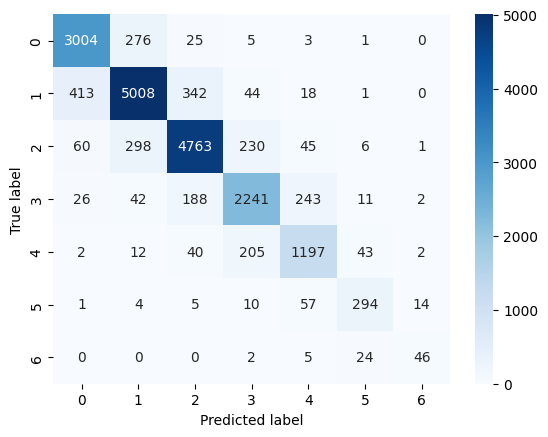

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues',  fmt='g')
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

## **예측 결과 출력**

In [20]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=original_train_y)

In [21]:
from xgboost import XGBClassifier


model = XGBClassifier(n_estimators=1000, learning_rate=0.2, max_depth=128, random_state = random_seed)
model.fit(original_train_X, original_train_y, sample_weight=classes_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=128, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
num_pred = model.predict(test)

In [23]:
num_to_rank = dict({0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G'})
pred = []
for num in num_pred:
  pred.append(num_to_rank[num])
print(pred[:10])

['B', 'A', 'A', 'C', 'C', 'A', 'B', 'C', 'B', 'C']


In [24]:
sample_submission = pd.read_csv('/content/drive/MyDrive/고객 대출등급 분류 해커톤/data/sample_submission.csv')
sample_submission['대출등급'] = pred
sample_submission

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,A
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


In [25]:
sample_submission.to_csv('baseline_submit.csv', index=False)